<h1><b>Задача по предсказанию рейтинга шоколада

<h3><b>Никнейм на Kaggle: 

# Описание задачи

In [111]:
# Даны характеристики шоколадок и по ним нужно предсказать их рейтинг.

# Описание данных
# Company - компания производитель
# Specific Bean Origin - географический регион происхождения
# REF - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)
# Review - дата публикации отзыва
# Cocoa Percent - процентное содержание какао
# Company Location - страна производитель
# Rating - экспертный рейтинг
# Bean Type - используемый сорт какао-бобов, если таковой имеется
# Broad Bean Origin - географический регион происхождения какао-бобов

# Файлы с данными
# choco_train.csv - тренировочные данные
# choco_test_new.csv - тестовые данные
# choco_sample_submission.csv - пример submission

# Импорт библиотек, константы

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [113]:
import warnings
warnings.filterwarnings("ignore")

In [114]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.preprocessing import LabelEncoder

In [115]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
import optuna

In [116]:
from association_metrics import CramersV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

In [117]:
SEED = 4784

<!-- # Загрузка данных -->

# Загрузка данных

In [118]:
# TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
# TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"
TRAIN = 'data\chocolate-rating\chocolate_train.csv'
TEST = 'data\chocolate-rating\chocolate_test_new.csv'

In [119]:
train = pd.read_csv(TRAIN)

In [120]:
test = pd.read_csv(TEST)

In [121]:
train['Bean Type'].value_counts().index[0]

'\xa0'

# Обзор данных

Описание данных
* Company - компания производитель
* Specific Bean Origin - географический регион происхождения
* REF - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)
* Review - дата публикации отзыва
* Cocoa Percent - процентное содержание какао
* Company Location - страна производитель
* Rating - экспертный рейтинг
* Bean Type - используемый сорт какао-бобов, если таковой имеется
* Broad Bean Origin - географический регион происхождения какао-бобов

In [122]:
test.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Ohiyo,"San Juan Estate, Gran Couva",1594,2015,70%,U.S.A.,Trinitario,Trinidad
1,Blanxart,Organic Dark,322,2009,72%,Spain,,
2,Brazen,Maya Mountain,1518,2015,80%,U.S.A.,Trinitario,Belize
3,Patric,Madagascar,439,2009,67%,U.S.A.,Trinitario,Madagascar
4,Potomac,"Upala, Batch 12",607,2010,82%,U.S.A.,Matina,Costa Rica


In [123]:
test.nunique()

Company                 244
Specific Bean Origin    385
REF                     338
Review                   12
Cocoa Percent            38
Company Location         42
Bean Type                20
Broad Bean Origin        60
dtype: int64

In [124]:
test.nunique()

Company                 244
Specific Bean Origin    385
REF                     338
Review                   12
Cocoa Percent            38
Company Location         42
Bean Type                20
Broad Bean Origin        60
dtype: int64

In [125]:
train = train.replace('\xa0', np.NaN)
test = test.replace('\xa0', np.NaN)

In [126]:
train_clean = train.copy()
test_clean = test.copy()

In [127]:
df_concat = pd.concat([train_clean, test_clean], axis=0)

In [128]:
def bean_type_mapping(value):
    bean_types = {
    'Amazonian': ['Amazon', 'Amazon mix', 'Amazon, ICS'],
    'Blend': ['Blend', 'Blend-Forastero,Criollo', 'Criollo, Forastero', 'Criollo, Trinitario', 
              'Forastero, Trinitario', 'Trinitario, Criollo', 'Trinitario, Forastero',
              'Trinitario, Nacional', 'Trinitario, TCGA'],
    'Criollo': ['Criollo', 'Criollo (Amarru)', 'Criollo (Ocumare 61)', 'Criollo (Ocumare 67)',
                'Criollo (Ocumare 77)', 'Criollo (Ocumare)', 'Criollo (Porcelana)', 'Criollo (Wild)', 'Criollo, +'],
    'Forastero': ['Forastero', 'Forastero (Amelonado)', 'Forastero (Arriba)', 'Forastero (Arriba) ASS',
                  'Forastero (Arriba) ASSS', 'Forastero (Catongo)', 'Forastero (Nacional)', 'Forastero (Parazinho)',
                  'Forastero(Arriba, CCN)'],
    'Nacional': ['Nacional', 'Nacional (Arriba)'],
    'Trinitario': ['Trinitario', 'Trinitario (85% Criollo)', 'Trinitario (Amelonado)', 'Trinitario (Scavina)']
    }
    
    for group, values in bean_types.items():
        if value in values:
            return group
    return value

In [129]:
def bb_origin_mapping(value):
    bb_origins = {
    'Carribean': ['Carribean', 'Carribean(DR/Jam/Tri)', 'Africa, Carribean, C. Am.'],
    'Colombia': ['Colombia', 'Colombia, Ecuador'],
    'Costa Rica': ['Costa Rica', 'Cost Rica, Ven'],
    'Dominican Republic': ['Dominican Republic', 'DR, Ecuador, Peru', 'Dom. Rep., Madagascar', 
                           'Domincan Republic', 'Dominican Rep., Bali'],
    'Ecuador': ['Ecuador', 'Ecuador, Costa Rica', 'Ecuador, Mad., PNG'],
    'Ghana': ['Ghana', 'Ghana & Madagascar', 'Ghana, Domin. Rep', 'Ghana, Panama, Ecuador'],
    'Grenada': ['Grenada', 'Gre., PNG, Haw., Haiti, Mad'],
    'Guatemala': ['Guatemala', 'Guat., D.R., Peru, Mad., PNG',],
    'Indonesia': ['Indonesia', 'Indonesia, Ghana'],
    'Madagascar': ['Madagascar', 'Madagascar & Ecuador','Mad., Java, PNG'],
    'Papua New Guinea': ['Papua New Guinea', 'PNG, Vanuatu, Mad'],
    'Peru': ['Peru', 'Peru(SMartin,Pangoa,nacional)', 'Peru, Belize', 'Peru, Dom. Rep', 'Peru, Ecuador',
    'Peru, Ecuador, Venezuela', 'Peru, Mad., Dom. Rep.', 'Peru, Madagascar'],
    'Sao Tome': ['Sao Tome', 'Sao Tome & Principe'],
    'South America': ['South America', 'South America, Africa', 'Central and S. America'],
    'Trinidad': ['Trinidad', 'Trinidad, Ecuador', 'Trinidad, Tobago', 'Trinidad-Tobago',],
    'Venezuela': ['Venezuela', 'Ven, Bolivia, D.R.', 'Ven, Trinidad, Ecuador', 'Ven., Indonesia, Ecuad.',
                  'Ven., Trinidad, Mad.', 'Ven.,Ecu.,Peru,Nic.', 'Venez,Africa,Brasil,Peru,Mex',
                  'Venezuela, Carribean', 'Venezuela, Dom. Rep.', 'Venezuela, Ghana', 'Venezuela, Java',
                  'Venezuela, Trinidad', 'Venezuela/ Ghana']
    }
    
    for group, values in bb_origins.items():
        if value in values:
            return group
    return value

In [130]:
def df_mapping(df):
    df['Bean Type'] = df['Bean Type'].apply(bean_type_mapping)
    df['Broad Bean Origin'] = df['Broad Bean Origin'].apply(bb_origin_mapping)

In [131]:
df_mapping(train_clean)
df_mapping(test_clean)

In [132]:
# stop

In [133]:
cols_temp = ['Company', 'Specific Bean Origin',
       'Company Location', 'Bean Type', 'Broad Bean Origin']

In [134]:
cols_temp

['Company',
 'Specific Bean Origin',
 'Company Location',
 'Bean Type',
 'Broad Bean Origin']

In [135]:
df_concat

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,NaN,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,NaN,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia
...,...,...,...,...,...,...,...,...,...
535,Monsieur Truffe,Papaua New Guinea,1391,2014,70%,Australia,NaN,NaN,Papua New Guinea
536,Cacao Hunters,Macondo,1816,2016,71%,Colombia,NaN,NaN,Colombia
537,Bonnat,Maragnam,1038,2013,75%,France,NaN,NaN,Brazil
538,Altus aka Cao Artisan,Acopagro,1728,2016,60%,U.S.A.,NaN,NaN,Peru


In [136]:
cramer_df = df_concat[cols_temp]
cramer_df = cramer_df.astype('category')

cramer = CramersV(cramer_df)
cramer = cramer.fit()

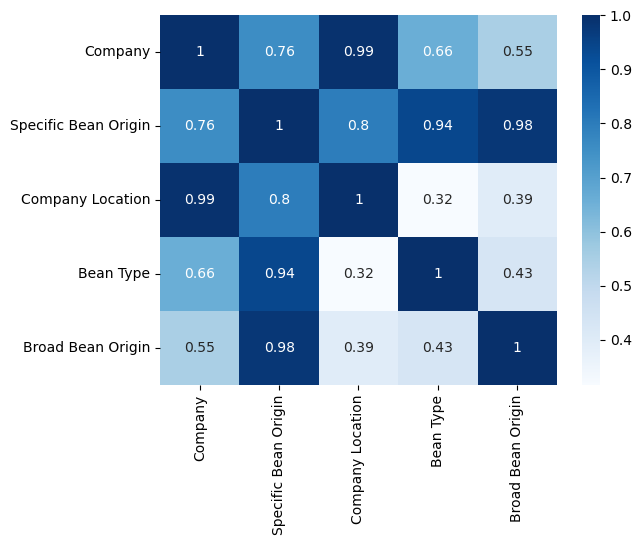

In [137]:
sns.heatmap(cramer, cmap='Blues', annot=True);

In [138]:
train_clean['Review'] = train_clean['Review'].astype('object')
test_clean['Review'] = test_clean['Review'].astype('object')

In [139]:
train.dtypes

Company                  object
Specific Bean Origin     object
REF                       int64
Review                    int64
Cocoa Percent            object
Company Location         object
Rating                  float64
Bean Type                object
Broad Bean Origin        object
dtype: object

In [140]:
train_clean.columns

Index(['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
       'Company Location', 'Rating', 'Bean Type', 'Broad Bean Origin'],
      dtype='object')

In [141]:
train_clean.isna().sum()

Company                   0
Specific Bean Origin      0
REF                       0
Review                    0
Cocoa Percent             0
Company Location          0
Rating                    0
Bean Type               629
Broad Bean Origin        56
dtype: int64

In [142]:
label_encoder = LabelEncoder()
encoded = label_encoder.fit_transform(df_concat[df_concat['Bean Type'].notna()]['Bean Type'])

In [143]:
cat_features = ['Company', 'Specific Bean Origin', 'Review', 'Cocoa Percent', 'Company Location', 'Broad Bean Origin']

In [144]:
df_concat['Broad Bean Origin'] = df_concat['Broad Bean Origin'].fillna('Temp')
train['Broad Bean Origin'] = train['Broad Bean Origin'].fillna('Temp')
test['Broad Bean Origin'] = test['Broad Bean Origin'].fillna('Temp')

In [145]:
model_1 = CatBoostClassifier(verbose = 0, cat_features = cat_features, task_type='GPU')
model_1.fit(df_concat[df_concat['Bean Type'].notna()].drop(columns = ['Rating','Bean Type']).dropna(), encoded)

In [146]:
y_bean = model_1.predict(train.drop(columns = ['Rating','Bean Type']))
y_bean_test = model_1.predict(test.drop(columns = ['Bean Type']))
y_concat_df = model_1.predict(df_concat.drop(columns = ['Rating','Bean Type']))

In [147]:
train['Bean Type'] = y_bean
test['Bean Type'] = y_bean_test
df_concat['Bean Type'] = y_concat_df

In [148]:
df_concat['Broad Bean Origin'] = df_concat['Broad Bean Origin'].replace('Temp', np.NaN)
train['Broad Bean Origin'] = train['Broad Bean Origin'].replace('Temp', np.NaN)
test['Broad Bean Origin'] = test['Broad Bean Origin'].replace('Temp', np.NaN)

In [149]:
label_encoder = LabelEncoder()
encoded = label_encoder.fit_transform(df_concat[df_concat['Broad Bean Origin'].notna()]['Broad Bean Origin'])

In [150]:
train['Broad Bean Origin'] = train['Broad Bean Origin'].replace('Temp', np.NaN)

In [151]:
cat_features = ['Company', 'Specific Bean Origin', 'Review', 'Cocoa Percent', 'Company Location', 'Bean Type']

In [152]:
model_2 = CatBoostClassifier(verbose = 1, cat_features = cat_features, task_type='GPU')
model_2.fit(df_concat[df_concat['Broad Bean Origin'].notna()].drop(columns = ['Rating','Broad Bean Origin']).dropna(), encoded)

Learning rate set to 0.072508
0:	learn: 4.2673273	total: 59.6ms	remaining: 59.5s
1:	learn: 4.0213056	total: 112ms	remaining: 56s
2:	learn: 3.8416190	total: 169ms	remaining: 56.1s
3:	learn: 3.7026285	total: 225ms	remaining: 55.9s
4:	learn: 3.5817081	total: 282ms	remaining: 56.1s
5:	learn: 3.4747024	total: 341ms	remaining: 56.5s
6:	learn: 3.3915377	total: 399ms	remaining: 56.6s
7:	learn: 3.3075593	total: 453ms	remaining: 56.2s
8:	learn: 3.2357054	total: 513ms	remaining: 56.5s
9:	learn: 3.1717178	total: 572ms	remaining: 56.6s
10:	learn: 3.1125161	total: 633ms	remaining: 56.9s
11:	learn: 3.0572824	total: 693ms	remaining: 57.1s
12:	learn: 3.0096181	total: 752ms	remaining: 57.1s
13:	learn: 2.9650197	total: 812ms	remaining: 57.2s
14:	learn: 2.9260514	total: 871ms	remaining: 57.2s
15:	learn: 2.8880312	total: 931ms	remaining: 57.3s
16:	learn: 2.8546045	total: 995ms	remaining: 57.5s
17:	learn: 2.8247808	total: 1.06s	remaining: 57.8s
18:	learn: 2.7682338	total: 1.11s	remaining: 57.4s
19:	learn: 2

In [153]:
y_bean = model_2.predict(train.drop(columns = ['Rating','Broad Bean Origin']))
y_bean_test = model_2.predict(test.drop(columns = ['Broad Bean Origin']))

In [154]:
train['Broad Bean Origin'] = y_bean
test['Broad Bean Origin'] = y_bean_test

In [155]:
train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,32,90
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,7,90
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,17,75
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,32,20
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,32,10


In [156]:
train.isna().sum()

Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Rating                  0
Bean Type               0
Broad Bean Origin       0
dtype: int64

In [157]:
test.isna().sum()

Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Bean Type               0
Broad Bean Origin       0
dtype: int64

In [158]:
train.dtypes

Company                  object
Specific Bean Origin     object
REF                       int64
Review                    int64
Cocoa Percent            object
Company Location         object
Rating                  float64
Bean Type                 int64
Broad Bean Origin         int64
dtype: object

In [159]:
train['Review'] = train['Review'].astype(np.int32)
test['Review'] = test['Review'].astype(np.int32)

train['Cocoa Percent'] = train['Cocoa Percent'].str.rstrip('%').astype(np.float32)
test['Cocoa Percent'] = test['Cocoa Percent'].str.rstrip('%').astype(np.float32)

In [160]:
train['Review / REF'] = train['Review'] / train['REF']
test['Review / REF'] = test['Review'] / train['REF']

cocoa_precent_mean = train['Cocoa Percent'].mean()

train['Cocoa Percent Deviation'] = train['Cocoa Percent'] - cocoa_precent_mean
test['Cocoa Percent Deviation'] = test['Cocoa Percent'] - cocoa_precent_mean

In [161]:
train['Review'] = train['Review'].astype('object')

test['Review'] = test['Review'].astype('object')

In [162]:
train.dtypes

Company                     object
Specific Bean Origin        object
REF                          int64
Review                      object
Cocoa Percent              float32
Company Location            object
Rating                     float64
Bean Type                    int64
Broad Bean Origin            int64
Review / REF               float64
Cocoa Percent Deviation    float32
dtype: object

In [163]:
# ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
# 'Company Location', 'Bean Type', 'Broad Bean Origin']

# cols = ['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
# 'Company Location', 'Bean Type', 'Broad Bean Origin']

In [175]:
X = train.drop(columns=['Rating', 'REF'])
y = train['Rating']
test = test.drop(columns=['REF'])

In [178]:
mm_scaler = MinMaxScaler()
num_cols = X.select_dtypes(include='number').columns.tolist()
# num_cols.remove('Rating')

X[num_cols] = mm_scaler.fit_transform(X[num_cols])  
test[num_cols] = mm_scaler.transform(test[num_cols])

In [179]:
X

,Company,Specific Bean Origin,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin,Review / REF,Cocoa Percent Deviation
0,Willie's Cacao,Rio Caribe,2009,0.481481,U.K.,1.000000,0.917526,0.008403,0.481481
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",2010,0.481481,Switzerland,0.166667,0.917526,0.007305,0.481481
2,Dark Forest,Tanzania,2015,0.444444,U.S.A.,0.500000,0.762887,0.000658,0.444444
3,Brasstown aka It's Chocolate,Cooproagro,2013,0.481481,U.S.A.,1.000000,0.195876,0.001889,0.481481
4,Pralus,"Java, Indonesie",2006,0.537037,France,1.000000,0.092784,0.154071,0.537037
...,...,...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,Madagascar,2009,0.629630,U.K.,1.000000,0.453608,0.011248,0.629630
1251,Marana,Cusco,2016,0.444444,Peru,0.166667,0.556701,0.000092,0.444444
1252,Arete,Nacional,2015,0.407407,U.S.A.,0.766667,0.206186,0.000700,0.407407
1253,Fresco,"Conacado, #212, LR, SC",2011,0.481481,U.S.A.,1.000000,0.195876,0.005246,0.481481


In [180]:
X.dtypes

Company                     object
Specific Bean Origin        object
Review                      object
Cocoa Percent              float64
Company Location            object
Bean Type                  float64
Broad Bean Origin          float64
Review / REF               float64
Cocoa Percent Deviation    float64
dtype: object

In [181]:
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name in ['category', 'object']]

## Обучение и подбор гиперпараметров

In [182]:
# def objective_catboost(trial):

#     params = {
#         'max_depth': 4,
#         'learning_rate': trial.suggest_float("learning_rate", 0.0005, 0.2, log=True),    # Скорость обучения
#         'n_estimators': trial.suggest_int("n_estimators", 1800, 3000),
#         'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),   # Коэффициент L2-регуляризации
#         'random_strength': trial.suggest_float("random_strength", 0, 10),   # Степень случайности
#         'bagging_temperature':  trial.suggest_float("bagging_temperature", 0, 1),   # Интенсивность бэггинга
#         # 'grow_policy': 'SymmetricTree',
#         # 'border_count': trial.suggest_int("border_count", 32, 255)
#         # 'iterations': trial.suggest_int('iterations', 100, 300),  # Количество итераций
#         # 'depth': trial.suggest_int('depth', 3, 4, 5),  # Глубина деревьев
#         # 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Скорость обучения
#         # 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),  # Коэффициент L2-регуляризации
#         # 'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),  # Функция потерь
#         # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 20),  # Ранняя остановка
#         # 'border_count': trial.suggest_categorical('border_count', [32, 128]),  # Количество границ
#         # 'random_strength': trial.suggest_float('random_strength', 0.1, 10),  # Степень случайности
#         # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Интенсивность бэггинга
#         # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),    # Стратегия роста
#         # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 15),   # Минимальное количество объектов в листе
#         # 'rsm': trial.suggest_float('rsm', 0.8, 1.0),    # Доля признаков для каждого дерева

#     }
    
#     model = CatBoostRegressor(cat_features=cat_features, **params, silent=True)

#     score = cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=-1).mean()
#     return score

# study = optuna.create_study(direction="maximize")
# study.optimize(objective_catboost, n_trials=350, n_jobs=-1)

In [183]:
# [I 2025-05-16 12:42:43,696] Trial 245 finished with value: 0.2171704465102873 and parameters: {'learning_rate': 0.009039437713326022, 'n_estimators': 2273, 'l2_leaf_reg': 1.4513127455825996, 'random_strength': 8.542817281162387, 'bagging_temperature': 0.3744773241174496}. Best is trial 245 with value: 0.2171704465102873.

# params = study.best_params
params = {'learning_rate': 0.009039437713326022, 'n_estimators': 2273, 'l2_leaf_reg': 1.4513127455825996, 'random_strength': 8.542817281162387, 'bagging_temperature': 0.3744773241174496}
model = CatBoostRegressor(cat_features=cat_features, **params, silent=True, task_type='GPU')
model.fit(X, y)

In [184]:
pred = model.predict(test)

In [185]:
test = test.copy()
result = pd.DataFrame()
result['id'] = np.arange(len(test))
result['Rating'] = pred

result[['id','Rating']].to_csv("choko_submission_135.csv", index=False)

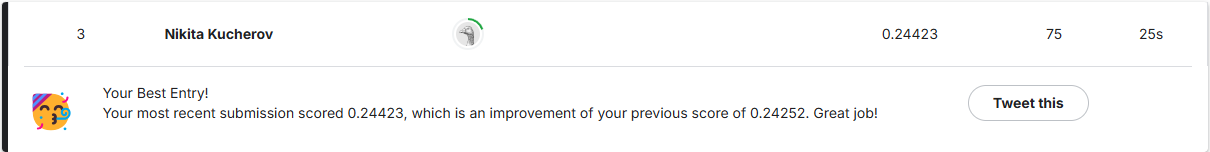